# LLM Powered Medical Case Sheet Ingestion
## Outline
1. Data Cleansing
2. Prompt Definition
3. Entity & Relationship Extraction
4. Neo4j Cypher Generation
5. Data Ingestion

In [1]:
%%capture
%pip install graphdatascience
%pip install openai
%pip install python-dotenv 
%pip install retry

In [2]:
import os
import openai
from retry import retry
import re
from string import Template
import json 
import ast
import time
import pandas as pd
from graphdatascience import GraphDataScience
import glob
from timeit import default_timer as timer
from dotenv import load_dotenv

## Data Cleansing

First, let's define a function that can help clean the input data. For the sake of simplicity, lets keep it simple. In the corpus, the data refers to some Figures like scan images. We dont have them and so will remove any such references.

In [2]:
def clean_text(text):
  clean = "\n".join([row for row in text.split("\n")])
  clean = re.sub(r'\(fig[^)]*\)', '', clean, flags=re.IGNORECASE)
  return clean

Let's take this case sheet and extract entities and relations using LLM

In [9]:
article_txt = """The patient was a 34-yr-old man who presented with complaints of fever and a chronic cough.
He was a smoker and had a history of pulmonary tuberculosis that had been treated and cured.
A computed tomographic (CT) scan revealed multiple tiny nodules in both lungs.
A thoracoscopic lung biopsy was taken from the right upper lobe.
The microscopic examination revealed a typical LCH.
The tumor cells had vesicular and grooved nuclei, and they formed small aggregations around the bronchioles (Fig.1).
The tumor cells were strongly positive for S-100 protein, vimentin, CD68 and CD1a.
There were infiltrations of lymphocytes and eosinophils around the tumor cells.
With performing additional radiologic examinations, no other organs were thought to be involved.
He quit smoking, but he received no other specific treatment.
He was well for the following one year.
After this, a follow-up CT scan was performed and it showed a 4 cm-sized mass in the left lower lobe, in addition to the multiple tiny nodules in both lungs (Fig.2).
A needle biopsy specimen revealed the possibility of a sarcoma; therefore, a lobectomy was performed.
Grossly, a 4 cm-sized poorly-circumscribed lobulated gray-white mass was found (Fig.3), and there were a few small satellite nodules around the main mass.
Microscopically, the tumor cells were aggregated in large sheets and they showed an infiltrative growth.
The cytologic features of some of the tumor cells were similar to those seen in a typical LCH.
However, many tumor cells showed overtly malignant cytologic features such as pleomorphic/hyperchromatic nuclei and prominent nucleoli (Fig.4), and multinucleated tumor giant cells were also found.
There were numerous mitotic figures ranging from 30 to 60 per 10 high power fields, and some of them were abnormal.
A few foci of typical LCH remained around the main tumor mass.
Immunohistochemically, the tumor cells were strongly positive for S-100 protein (Fig.5) and vimentin; they were also positive for CD68 (Dako N1577, Clone KPI), and focally positive for CD1a (Fig.6), and they were negative for cytokeratin, epithelial membrane antigen, CD3, CD20 and HMB45.
The ultrastructural analysis failed to demonstrate any Birbeck granules in the cytoplasm of the tumor cells.
Now, at five months after lobectomy, the patient is doing well with no significant change in the radiologic findings.
"""

## Prompt Definition

**⚠️** You need to duplicate `config.env.example` file in the left and rename as `config.env`. Edit the values in this file and provide the values for API keys and Neo4j credentials

In [3]:
load_dotenv('config.env', override=True)

openai.api_type = "azure" #I use Azure OpenAI. You might need to comment if you use the non-Azure instance
openai.api_base = os.getenv('OPENAI_API_BASE')
openai.api_version = os.getenv('OPENAI_API_VERSION')
openai.api_key = os.getenv('OPENAI_API_KEY')

This is a helper function to talk to the LLM with our prompt and text input

In [10]:
# GPT-4 Prompt to complete
@retry(tries=2, delay=5)
def process_gpt(system, 
                prompt):

    completion = openai.ChatCompletion.create(
        engine="gpt-4-32k",
        model="gpt-4-32k",
        max_tokens=25000,
        # Try to be as deterministic as possible
        temperature=0,
        messages=[
            {"role": "system", "content": system},
            {"role": "user", "content": prompt},
        ]
    )
    nlp_results = completion.choices[0].message.content
    return nlp_results

This is a simple prompt to start with. If the processing is very complex, you can also chain the prompts as and when required. I am going to use a single prompt here that helps me to extract the text strictly as per the Entities and Relationships defined. This is a simplification. In the real scenario, especially with medical records, you have to leverage on Domain experts to define the Ontology systematically and capture the important information. You might also be fine-tuning the model as and when required.

Also, instead of one single large model, you can also consider chaining a number of smaller ones as per your needs.

We are going with this Graph Schema for our Case Sheet:
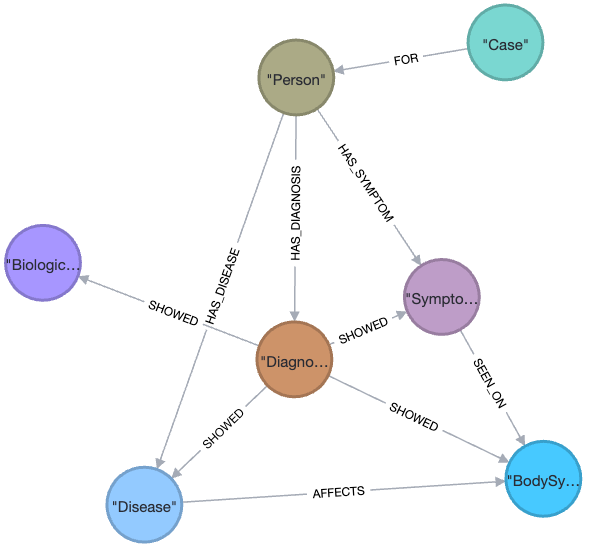

In [8]:
prompt1="""From the Case sheet for a patient below, extract the following Entities & relationships described in the mentioned format 
0. ALWAYS FINISH THE OUTPUT. Never send partial responses
1. First, look for these Entity types in the text and generate as comma-separated format similar to entity type.
   `id` property of each entity must be alphanumeric and must be unique among the entities. You will be referring this property to define the relationship between entities. Do not create new entity types that aren't mentioned below. Document must be summarized and stored inside Case entity under `summary` property. You will have to generate as many entities as needed as per the types below:
    Entity Types:
    label:'Case',id:string,summary:string //Case
    label:'Person',id:string,age:string,location:string,gender:string //Patient mentioned in the case
    label:'Symptom',id:string,description:string //Symptom Entity; `id` property is the name of the symptom, in lowercase & camel-case & should always start with an alphabet
    label:'Disease',id:string,name:string //Disease diagnosed now or previously as per the Case sheet; `id` property is the name of the disease, in lowercase & camel-case & should always start with an alphabet
    label:'BodySystem',id:string,name:string //Body Part affected. Eg: Chest, Lungs; id property is the name of the part, in lowercase & camel-case & should always start with an alphabet
    label:'Diagnosis',id:string,name:string,description:string,when:string //Diagnostic procedure conducted; `id` property is the summary of the Diagnosis, in lowercase & camel-case & should always start with an alphabet
    label:'Biological',id:string,name:string,description:string //Results identified from Diagnosis; `id` property is the summary of the Biological, in lowercase & camel-case & should always start with an alphabet
    
3. Next generate each relationships as triples of head, relationship and tail. To refer the head and tail entity, use their respective `id` property. Relationship property should be mentioned within brackets as comma-separated. They should follow these relationship types below. You will have to generate as many relationships as needed as defined below:
    Relationship types:
    case|FOR|person
    person|HAS_SYMPTOM{when:string,frequency:string,span:string}|symptom //the properties inside HAS_SYMPTOM gets populated from the Case sheet
    person|HAS_DISEASE{when:string}|disease //the properties inside HAS_DISEASE gets populated from the Case sheet
    symptom|SEEN_ON|chest
    disease|AFFECTS|heart
    person|HAS_DIAGNOSIS|diagnosis
    diagnosis|SHOWED|biological

The output should look like :
{
    "entities": [{"label":"Case","id":string,"summary":string}],
    "relationships": ["disease|AFFECTS|heart"]
}

Case Sheet:
$ctext
"""

Let's run our completion task with our LLM

In [12]:
%%time
def run_completion(prompt, results, ctext):
    try:
      system = "You are a helpful Medical Case Sheet expert who extracts relevant information and store them on a Neo4j Knowledge Graph"
      pr = Template(prompt).substitute(ctext=ctext)
      res = process_gpt(system, pr)
      results.append(json.loads(res.replace("\'", "'")))
      return results
    except Exception as e:
        print(e)

prompts = [prompt1]
results = []
for p in prompts:
  results = run_completion(p, results, clean_text(article_txt))
    

CPU times: user 186 ms, sys: 7.83 ms, total: 194 ms
Wall time: 23.8 s


## Neo4j Cypher Generation

The entities & relationships we got from the LLM have to be transformed to Cypher so we can ingest into Neo4j

In [13]:
#pre-processing results for uploading into Neo4j - helper function:
def get_prop_str(prop_dict, _id):
    s = []
    for key, val in prop_dict.items():
      if key != 'label' and key != 'id':
         s.append(_id+"."+key+' = "'+str(val).replace('\"', '"').replace('"', '\"')+'"') 
    return ' ON CREATE SET ' + ','.join(s)

def get_cypher_compliant_var(_id):
    return "_"+ re.sub(r'[\W_]', '', _id)

def generate_cypher(in_json):
    e_map = {}
    e_stmt = []
    r_stmt = []
    e_stmt_tpl = Template("($id:$label{id:'$key'})")
    r_stmt_tpl = Template("""
      MATCH $src
      MATCH $tgt
      MERGE ($src_id)-[:$rel]->($tgt_id)
    """)
    for obj in in_json:
      for j in obj['entities']:
          props = ''
          label = j['label']
          id = j['id']
          if label == 'Case':
                id = 'c'+str(time.time_ns())
          elif label == 'Person':
                id = 'p'+str(time.time_ns())
          varname = get_cypher_compliant_var(j['id'])
          stmt = e_stmt_tpl.substitute(id=varname, label=label, key=id)
          e_map[varname] = stmt
          e_stmt.append('MERGE '+ stmt + get_prop_str(j, varname))

      for st in obj['relationships']:
          rels = st.split("|")
          src_id = get_cypher_compliant_var(rels[0].strip())
          rel = rels[1].strip()
          tgt_id = get_cypher_compliant_var(rels[2].strip())
          stmt = r_stmt_tpl.substitute(
              src_id=src_id, tgt_id=tgt_id, src=e_map[src_id], tgt=e_map[tgt_id], rel=rel)
          
          r_stmt.append(stmt)

    return e_stmt, r_stmt

In [14]:
ent_cyp, rel_cyp = generate_cypher(results)

## Data Ingestion

In [4]:
connectionUrl = os.getenv('NEO4J_CONN_URL')
username = os.getenv('NEO4J_USER')
password = os.getenv('NEO4J_PASSWORD')

In [5]:
gds = GraphDataScience(connectionUrl, auth=(username, password))
gds.version()

'2.3.4+17'

Before loading the data, create constraints as below

In [6]:
gds.run_cypher('CREATE CONSTRAINT unique_case_id IF NOT EXISTS FOR (n:Case) REQUIRE n.id IS UNIQUE')
gds.run_cypher('CREATE CONSTRAINT unique_person_id IF NOT EXISTS FOR (n:Person) REQUIRE (n.id) IS UNIQUE')
gds.run_cypher('CREATE CONSTRAINT unique_symptom_id IF NOT EXISTS FOR (n:Symptom) REQUIRE (n.id) IS UNIQUE')
gds.run_cypher('CREATE CONSTRAINT unique_disease_id IF NOT EXISTS FOR (n:Disease) REQUIRE n.id IS UNIQUE')
gds.run_cypher('CREATE CONSTRAINT unique_bodysys_id IF NOT EXISTS FOR (n:BodySystem) REQUIRE n.id IS UNIQUE')
gds.run_cypher('CREATE CONSTRAINT unique_diag_id IF NOT EXISTS FOR (n:Diagnosis) REQUIRE n.id IS UNIQUE')
gds.run_cypher('CREATE CONSTRAINT unique_biological_id IF NOT EXISTS FOR (n:Biological) REQUIRE n.id IS UNIQUE')

""


Ingest the entities

In [177]:
%%time
for e in ent_cyp:
    gds.run_cypher(e)


CPU times: user 35.4 ms, sys: 0 ns, total: 35.4 ms
Wall time: 1.49 s


Ingest relationships now

In [178]:
%%time
for r in rel_cyp:
    gds.run_cypher(r)

CPU times: user 51.5 ms, sys: 0 ns, total: 51.5 ms
Wall time: 2.72 s


This is a helper function to ingest all case sheets inside the `data/` directory

In [289]:
def run_pipeline(count=191):
    txt_files = glob.glob("data/case_sheets/*.txt")[0:count]
    print(f"Running pipeline for {len(txt_files)} files")
    failed_files = process_pipeline(txt_files)
    print(failed_files)
    return failed_files

def process_pipeline(files):
    failed_files = []
    for f in files:
        try:
            with open(f, 'r') as file:
                print(f"  {f}: Reading File...")
                data = file.read().rstrip()
                text = clean_text(data)
                print(f"    {f}: Extracting E & R")
                results = extract_entities_relationships(f, text)
                print(f"    {f}: Generating Cypher")
                ent_cyp, rel_cyp = generate_cypher(results)
                print(f"    {f}: Ingesting Entities")
                for e in ent_cyp:
                    gds.run_cypher(e)
                print(f"    {f}: Ingesting Relationships")
                for r in rel_cyp:
                    gds.run_cypher(r)
                print(f"    {f}: Processing DONE")
        except Exception as e:
            print(f"    {f}: Processing Failed with exception {e}")
            failed_files.append(f)
    return failed_files
            
def extract_entities_relationships(f, text):
    start = timer()
    system = "You are a helpful Medical Case Sheet expert who extracts relevant information and store them on a Neo4j Knowledge Graph"
    prompts = [prompt1]
    all_cypher = ""
    results = []
    for p in prompts:
      p = Template(p).substitute(ctext=text)
      res = process_gpt(system, p)
      results.append(json.loads(res))
    end = timer()
    elapsed = (end-start)
    print(f"    {f}: E & R took {elapsed}secs")
    return results

In [ ]:
%%time
failed_files = run_pipeline(200)

If processing failed for some files due to API Rate limit or some other error, you can retry as below

In [ ]:
%%time
failed_files = process_pipeline(failed_files)
failed_files